In [1]:
"""
Allow some options on the plots (zoom, resize, save),
/!\: have to wait to the end of the cell's execution
before launch the next
"""
# %matplotlib notebook

# standard plot inside the netbook, but no options available
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

import birdsonganalysis as bsa

# utils module from current folder
from utils import (boari_synth_song_error, draw_learning_curve,
                   carac_to_calculate_err_of_synth, err_per_feat)
from cmp_2_sim import plot_gesture_starts

# Allow to import the modules in the model folder
sys.path.append('../model/')
from measures import normalize_and_center, bsa_measure
from song_fitter import SongModel, get_scores
from synth import synthesize

sns.set_palette('colorblind')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 5

In [2]:
# path of the folder with the results
path = '../model/res/'

# -- 1 simulation --
# path += 'seed2+mutate_best_models_elite+512_neg_beta_no_pitch+default_coef_0p+500_diversity_th'

# -- Cluster simulations --
path += 'nlm_div_th_test_180713_173751/'

# -- Definition of each parameter --
# params = []
# params.append("seed0")
# params.append("mutate_best_models_elite")
# params.append("rescal_meas_512")
# params.append("default_coef")
# path += '+'.join(params)

# -- All parameters are defined at the same time --
param_name = "seed3+nlm_div_th_test+0p_1rms+2000_diversity_th"
path += param_name

if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

In [3]:
# load the parameters used for the simulation
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
    
try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    print('No desc for this run.')

No desc for this run.


# Simulation parameters

In [4]:
out = '| key | value |\n|---|---|\n' 
out += '\n'.join(['| {} | {} |'.format(key, run_param[key]) for key in sorted(run_param.keys())])
display(Markdown(out))

| key | value |
|---|---|
| coefs | {'goodness': 1, 'rms': 1, 'pitch': 0, 'fm': 1, 'entropy': 1, 'am': 1, 'amplitude': 1} |
| comp | linalg |
| concurrent | 3 |
| days | 30 |
| dev | [0.1, 0.1, 0.05, 1, 0.05, 0.05, 0.05, 1, 0.001, 0.001, 0.005, 100, 0.2, 0.05, 0.01, 0.05, 1, 0.005] |
| diversity_threshold | 2000 |
| dlm | optimise_gesture_whole_local_search |
| iter_per_train | 20 |
| maxs | [50, 4, 3.141592653589793, 40000, 50, 4, 3.141592653589793, 40000, 50, 5, 3.141592653589793, 40000, 10, 50, 3, 3.141592653589793, 1000, 0] |
| mins | [-50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -50, 0, -3.141592653589793, 0, -5, -50, 0, -3.141592653589793, 0, -3] |
| name | seed3+nlm_div_th_test+0p_1rms+2000_diversity_th |
| night_concurrent | 20 |
| nlm | mutate_microbial_diversity_uniform |
| prior | [0, 0, 3.141592653589793, 15, 0, 0, 0.39269908169872414, 45, 0, 0, 0, 5000, 0, 0, 0, 0, 0, -0.15] |
| replay | 200 |
| seed | 3 |
| train_per_day | 200 |
| tutor | ../data/boari_short.wav |

# Get data

In [5]:
# -- Tutor --
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
tutor = normalize_and_center(tutor)

# -- Songs learned --
outputs = []

try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    try:
        warnings.warn('Learning not over')
        with open(join(path, 'data_cur.pkl'), 'rb') as f:
            songlog = pickle.load(f)
    except FileNotFoundError:
        print("Error: no data files")
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)

day_index = -1 # -1: last day

best = np.argmin(rd['scores'].iloc[day_index])
smodels = rd['songs'].iloc[day_index]
ab = smodels[best].gen_alphabeta()
song = smodels[best].gen_sound()

g_starts = []
for i, gesture in enumerate(smodels[best].gestures):
            g_starts.append(gesture[0])

# outputs contains the different final songs
outputs = [smodel.gen_sound() for smodel in smodels]

# Allow to split the gesture on the alpha and beta plots
for start, g in smodels[best].gestures:
    ab[start] = np.nan

# -- Boari's Synthesized song --
song_name = basename(run_param['tutor']).split('.')[0]
sr, synth_song = wavfile.read('../data/{}_out.wav'.format(song_name))
synth_ab = np.loadtxt('../data/{}_ab.dat'.format(song_name))
"""
add the missing samples to synth_ab because
The Boari's algorithm removes 612 samples by generating the synthesized song 
"""
pad0 = synth_ab[-1,0] * np.ones((612,1))
pad1 = synth_ab[-1,1] * np.ones((612,1))
pad = np.concatenate((pad0, pad1), axis=1)
synth_ab = np.concatenate((synth_ab, pad), axis=0)

# Boari's GTE detection
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))

In [57]:
# tmp: pour check l'avancée des simu du cluster
# rd

# Sound waves and spectral derivatives

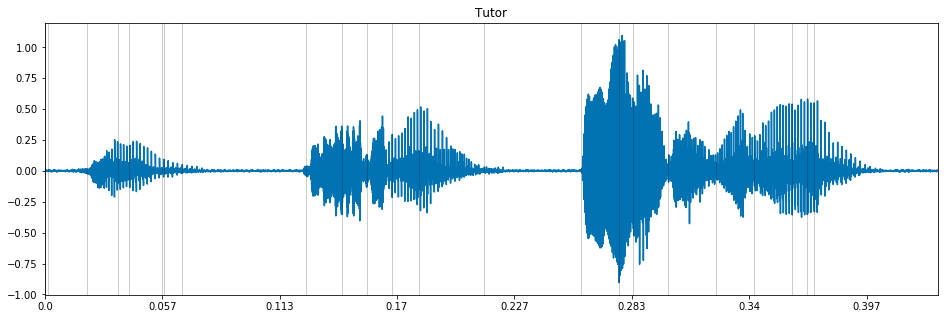

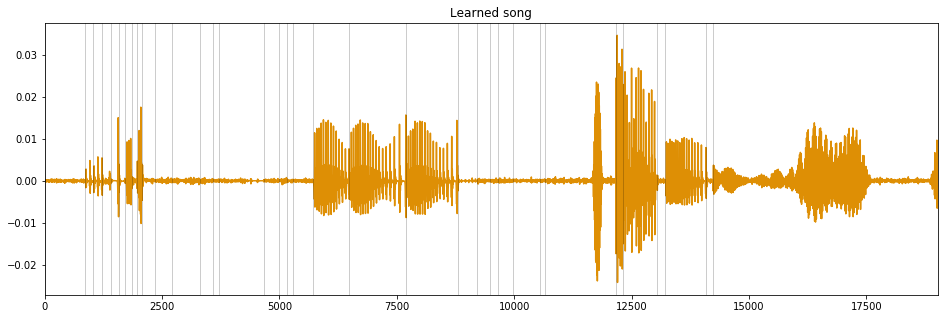

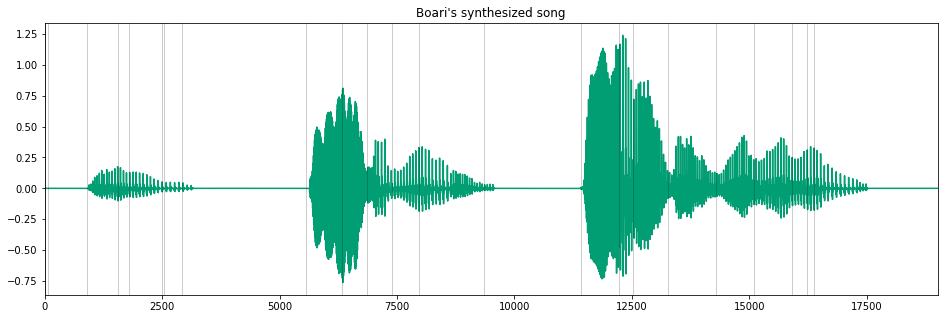

In [7]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(tutor)
plot_gesture_starts(gtes)
plt.xlim(0,len(tutor))
x_ticks_loc = np.arange(0, 19000, 2500)
x_ticks_label = (x_ticks_loc / bsa.SR).tolist()
x_ticks_label = [round(elt, 3) for elt in x_ticks_label]
plt.xticks(x_ticks_loc, x_ticks_label)
plt.title("Tutor")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(song, color="C1")
plt.xlim(0,len(song))
plot_gesture_starts(g_starts)
plt.title("Learned song")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_song, color="C2")
plot_gesture_starts(gtes)
plt.xlim(0,len(synth_song))
plt.title("Boari's synthesized song")
plt.show()

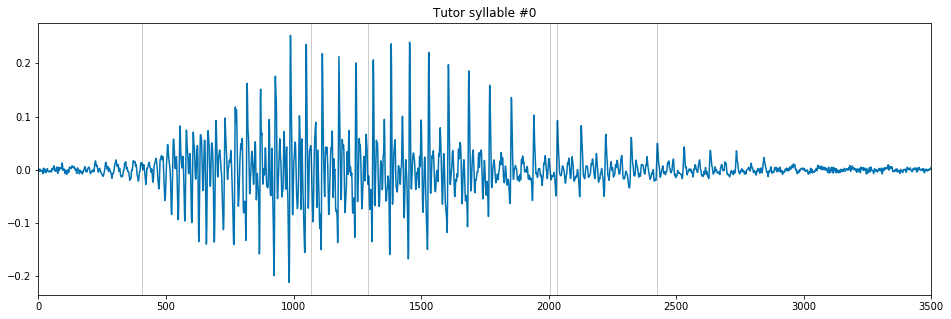

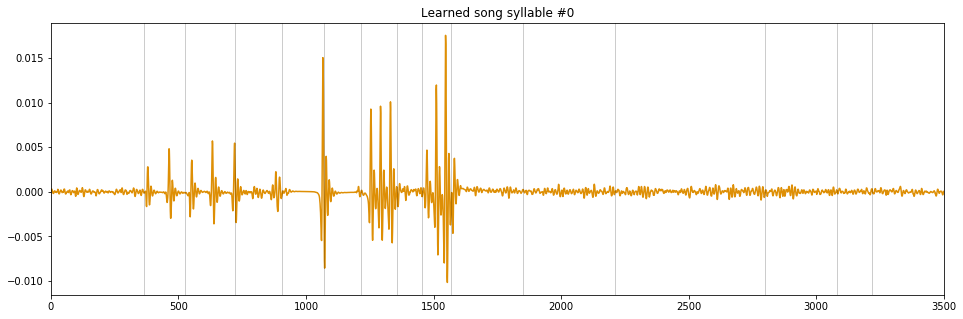

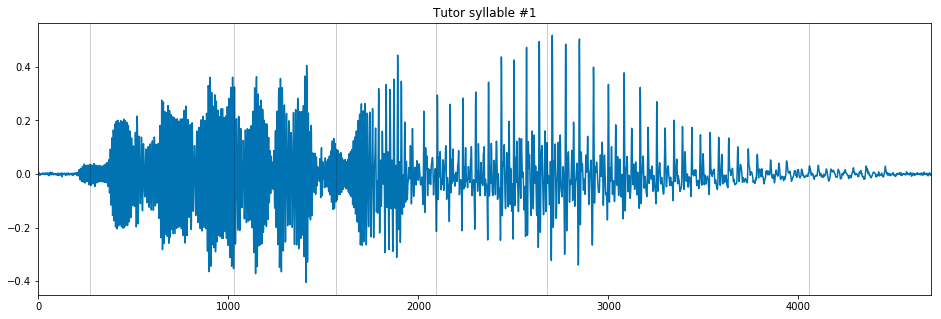

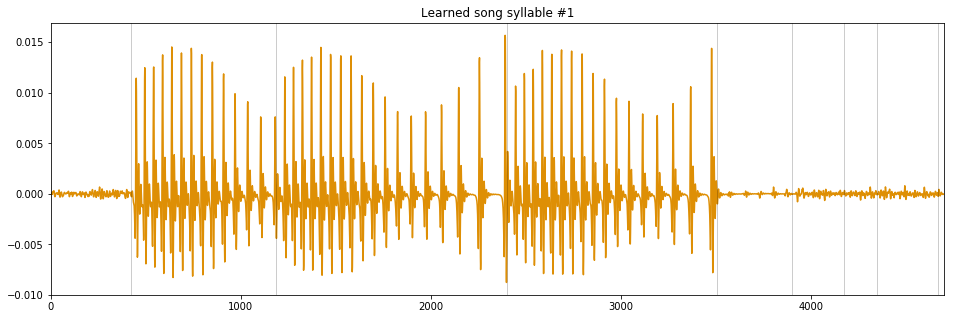

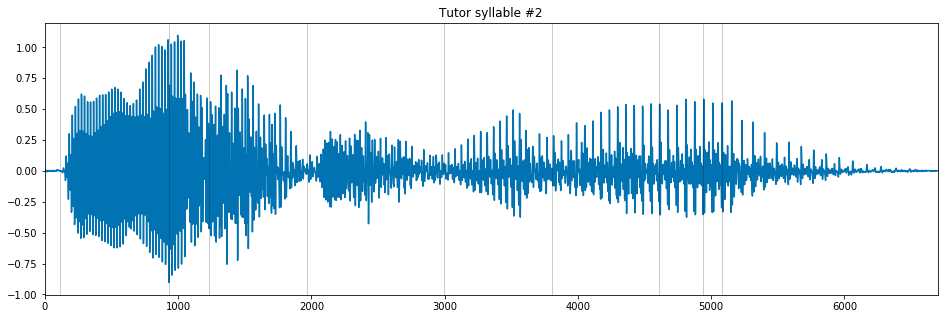

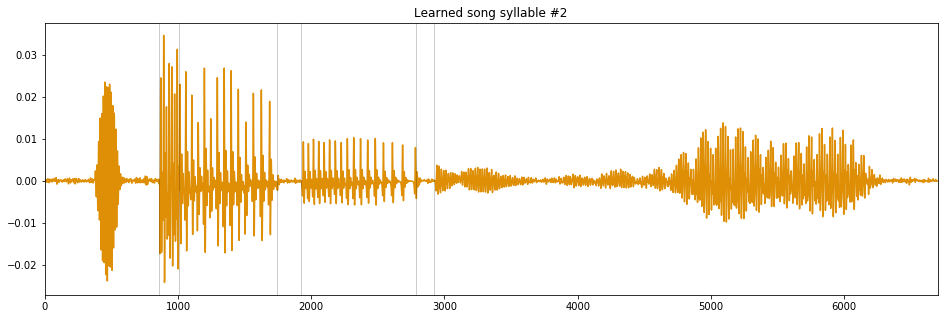

In [8]:
starts = [500, 5300, 11300]
ends = [4000, 10000, 18000]
for i in range(len(starts)):
    tutor_syll = tutor[starts[i]:ends[i]]
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(tutor_syll)
    plot_gesture_starts(gtes - starts[i])
    plt.xlim(0,len(tutor_syll))
    plt.title("Tutor syllable #{}".format(i))
    plt.show()
    
    song_syll = song[starts[i]:ends[i]]
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(song_syll, color="C1")
    plot_gesture_starts(np.array(g_starts) - starts[i])
    plt.xlim(0,len(song_syll))
    plt.title("Learned song syllable #{}".format(i))
    plt.show()

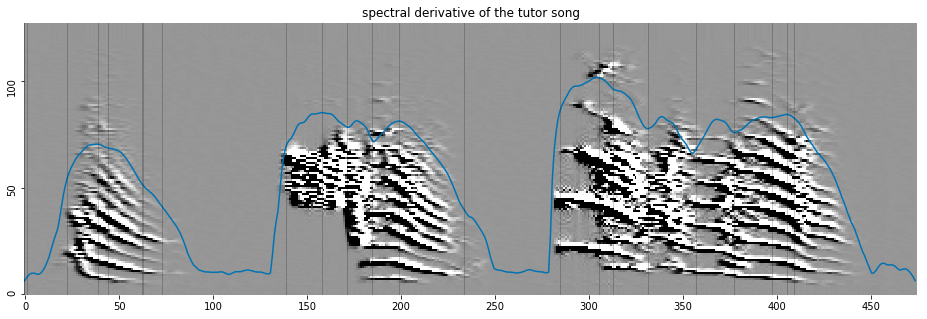

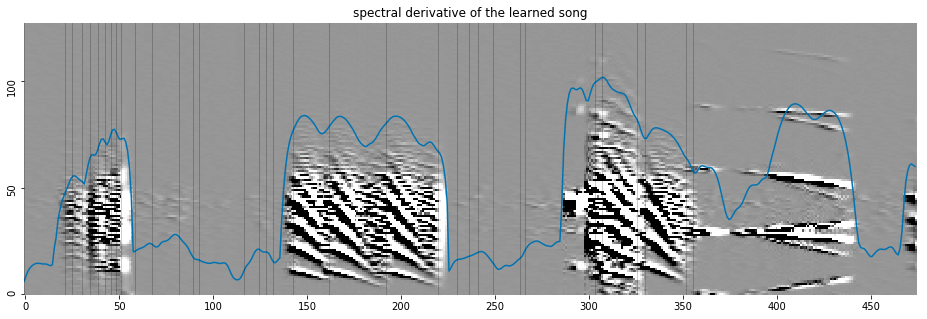

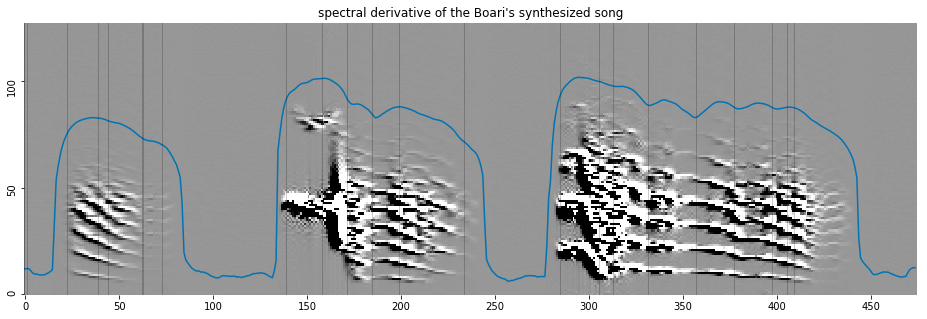

In [9]:
zoom = bsa.FFT_SIZE / bsa.FREQ_RANGE / 4

tutor_spec = bsa.spectral_derivs(tutor,
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
song_spec = bsa.spectral_derivs(song, 
                                bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)
synth_spec = bsa.spectral_derivs(synth_song, 
                                 bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE)

# Spectral derivative of the tutor song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(tutor_spec, contrast=0.01, ax=ax,
                         freq_range=bsa.FREQ_RANGE)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
plot_gesture_starts(gtes, scale=bsa.FFT_STEP)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

# Spectral derivative of the learned song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(song_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song,
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plot_gesture_starts(g_starts, scale=bsa.FFT_STEP)
plt.title("spectral derivative of the learned song")
plt.show(fig)

# Spectral derivative of the Boari's synthesized song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(synth_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth_song,
                                      bsa.FREQ_RANGE, bsa.FFT_STEP, bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
plot_gesture_starts(gtes, scale=bsa.FFT_STEP)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the Boari's synthesized song")
plt.show(fig)

# Sound

In [10]:
# Sound of the tutor song
display(Audio(tutor, rate=bsa.SR))

In [11]:
# Audio of the final songs
for output in outputs:
    display(Audio(output, rate=bsa.SR))

In [12]:
# Audio of the Boari's synth song
display(Audio(synth_song, rate=bsa.SR))

# Save learned song wav file

In [13]:
# normalize to get the sound louder
# wav_song = normalize_and_center(song)

# wavfile.write(filename="{}_song.wav".format(param_name),
#               rate=bsa.SR,data=wav_song)

# Get features

In [14]:
# -- Initial tutor features: --
# used as parameter to rescale the others features
tfeat= bsa.all_song_features(tutor, bsa.SR,
                             freq_range=bsa.FREQ_RANGE,
                             fft_step=bsa.FFT_STEP,
                             fft_size=bsa.FFT_SIZE)

# -- Tutor features --
tutor_feat = bsa.rescaling_with_tutor_values(tfeat, tfeat)

# -- Learned song features --
sfeat = bsa.all_song_features(song, bsa.SR,
                              freq_range=bsa.FREQ_RANGE,
                              fft_step=bsa.FFT_STEP,
                              fft_size=bsa.FFT_SIZE)
song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# -- Boari's synth song features --
syfeat = bsa.all_song_features(synth_song, bsa.SR,
                               freq_range=bsa.FREQ_RANGE,
                               fft_step=bsa.FFT_STEP,
                               fft_size=bsa.FFT_SIZE)
synth_feat = bsa.rescaling_with_tutor_values(tfeat, syfeat)

# Features comparison

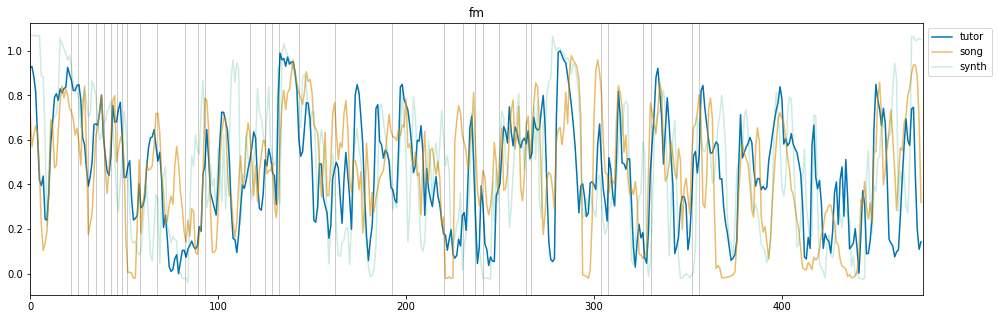

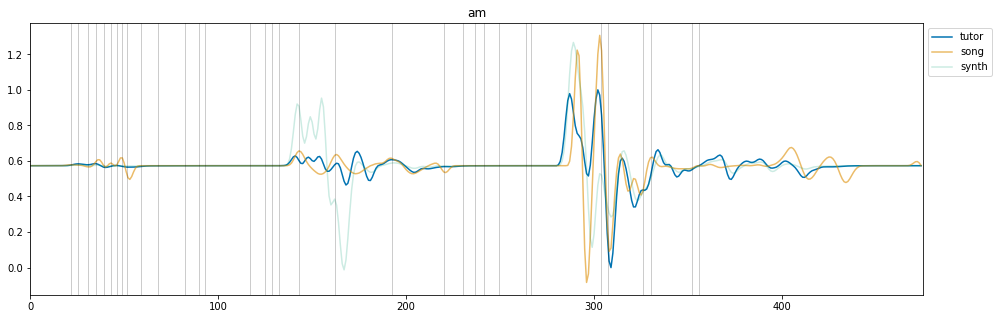

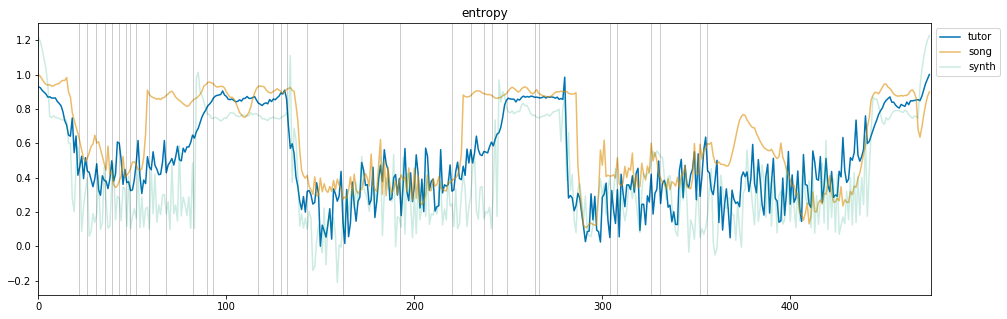

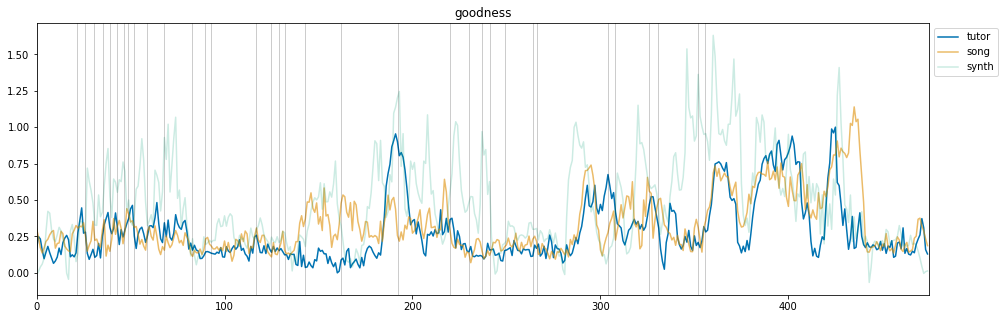

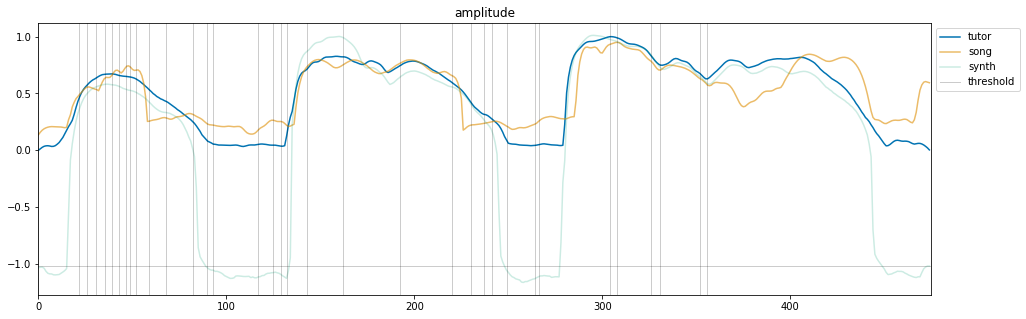

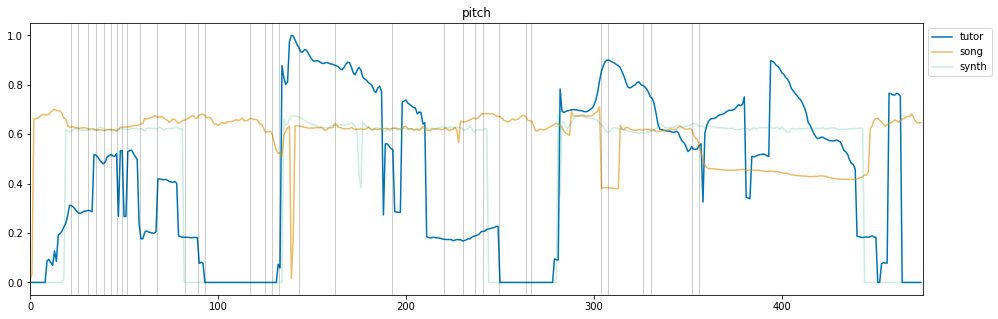

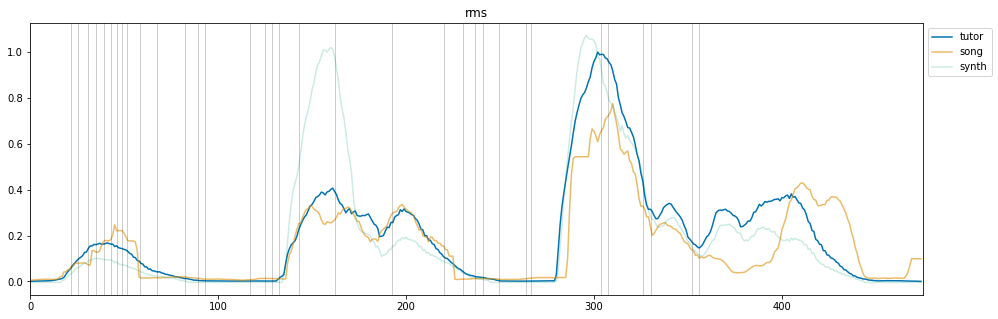

In [59]:
# Retrieve the threshold to plot it
amp, th = carac_to_calculate_err_of_synth(synth_song,
                                          tfeat["amplitude"])

fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude', 'pitch', 'rms']
for fname in fnames:
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(tutor_feat[fname], label="tutor")
    plt.plot(song_feat[fname], alpha=0.6, label="song")
    plt.plot(synth_feat[fname], alpha=0.2, label="synth")
    plot_gesture_starts(g_starts, scale=40)
    plt.xlim(0, len(tutor_feat[fname]))
    if fname == 'amplitude':
        plt.axhline(y=th, color="k",
                    linewidth=1, alpha=0.2, label="threshold")
    plt.title(fname)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

coefficients: {'goodness': 1, 'rms': 1, 'pitch': 0, 'fm': 1, 'entropy': 1, 'am': 1, 'amplitude': 1}
Boari's score on boari_short.wav : 14.989055730662681
Best song model score: 9.307159033875688


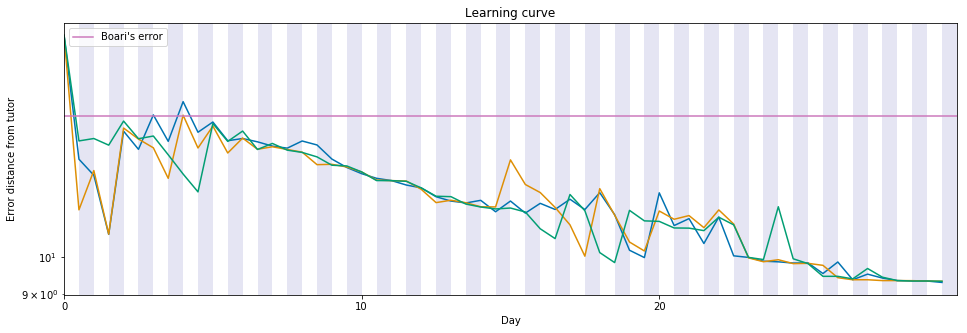

In [16]:
# /!\: if tutor_feat parameter is defined,
# use rescaling to calculate the error
score = boari_synth_song_error(tutor,
                               synth_song,
                               run_param['coefs'],
                               tutor_feat=tfeat)

best_score = rd['scores'].iloc[day_index][best]
print("coefficients: {}".format(run_param['coefs']))
print("Boari's score on {}.wav : {}".format(song_name, score))
print("Best song model score: {}".format(best_score))

# Plot
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
ax = draw_learning_curve(rd, ax=ax)
ax.axhline(y=score, color='C4', linestyle='-',
           label="Boari's error")
ax.set_yscale('log')
ax.legend()
plt.show(fig)

coefficients: {'goodness': 1, 'rms': 1, 'pitch': 0, 'fm': 1, 'entropy': 1, 'am': 1, 'amplitude': 1}
Boari's score on boari_short.wav : 14.989055730662681
Best song model score: 9.307159033875688


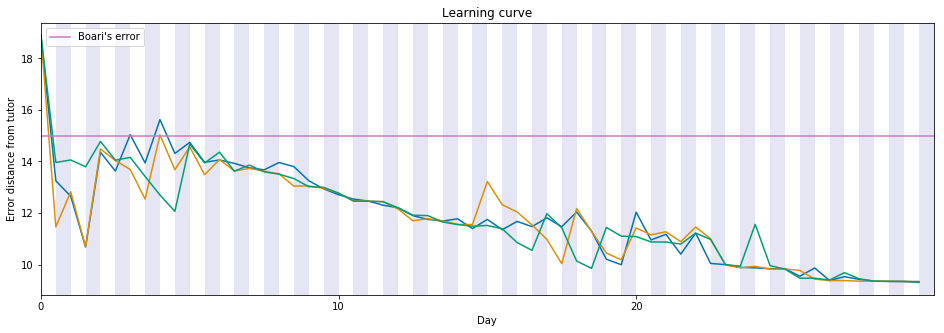

In [17]:
# /!\: if tutor_feat parameter is defined,
# use rescaling to calculate the error
score = boari_synth_song_error(tutor,
                               synth_song,
                               run_param['coefs'],
                               tutor_feat=tfeat)

best_score = rd['scores'].iloc[day_index][best]
print("coefficients: {}".format(run_param['coefs']))
print("Boari's score on {}.wav : {}".format(song_name, score))
print("Best song model score: {}".format(best_score))

# Plot
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
ax = draw_learning_curve(rd, ax=ax)
ax.axhline(y=score, color='C4', linestyle='-',
           label="Boari's error")
ax.legend()
plt.show(fig)

In [18]:
print("first scores: {}".format(rd['scores'].iloc[0]))
print("last scores: {}".format(rd['scores'].iloc[day_index]))
print("the best song index: {}".format(best))

first scores: [18.89435907 18.89435907 18.89435907]
last scores: [9.30715903 9.339835   9.33858337]
the best song index: 0


In [19]:
mean_score = np.mean(rd['scores'].iloc[day_index])
print("mean score score at index {}: {}".format(day_index, mean_score))

mean score score at index -1: 9.3285258028815


# Gesture analysis

In [20]:
print([round(elt, 2) for elt in run_param['prior'][:4]])
print([round(elt, 2) for elt in run_param['prior'][4:8]])
print([round(elt, 2) for elt in run_param['prior'][8:12]])
print(run_param['prior'][13])
print([round(elt, 2) for elt in run_param['prior'][13:]])
print()
print()

np.set_printoptions(suppress=True,
                    formatter={'float_kind':'{:0.2f}'.format})

for gesture in smodels[best].gestures:
    print("start: {}".format(gesture[0]))
    str_alpha = str(gesture[1][:4])
    str_alpha += '\n'+str(gesture[1][4:8])
    str_alpha += '\n'+str(gesture[1][8:12])
    str_alpha += '\n'+'['+str(round(gesture[1][12], 2))+']'
    str_beta = str(gesture[1][13:])
    print("parameters:\n{}\n{}".format(str_alpha, str_beta))

# Come back to default values
np.set_printoptions(suppress=None,
                formatter=None)

[0, 0, 3.14, 15]
[0, 0, 0.39, 45]
[0, 0, 0, 5000]
0
[0, 0, 0, 0, -0.15]


start: 0
parameters:
[1.59 0.72 3.14 15.16]
[1.31 0.46 -1.39 51.29]
[0.05 0.04 -0.02 5028.68]
[-0.48]
[0.45 0.14 1.25 2.26 -0.24]
start: 866
parameters:
[0.36 0.00 3.14 13.33]
[-0.30 0.00 -0.09 51.00]
[0.13 0.03 0.05 4971.36]
[0.03]
[0.46 0.09 0.73 0.00 -0.06]
start: 1027
parameters:
[0.36 0.00 3.14 13.33]
[-0.30 0.00 -0.09 51.00]
[0.13 0.03 0.05 4971.36]
[0.03]
[0.46 0.09 0.73 0.00 -0.06]
start: 1223
parameters:
[0.32 0.28 2.89 7.31]
[-2.33 1.23 0.29 54.93]
[0.03 0.08 0.04 4968.78]
[-1.28]
[-0.41 0.08 0.08 0.93 -0.45]
start: 1407
parameters:
[-1.01 0.36 2.16 13.83]
[0.54 0.63 0.01 47.37]
[-0.10 0.00 0.08 5003.69]
[-0.65]
[1.24 0.29 1.46 2.02 0.00]
start: 1572
parameters:
[2.02 1.19 2.90 9.89]
[-1.15 1.30 0.24 51.74]
[-0.22 0.00 0.10 5021.63]
[-2.63]
[0.35 0.32 2.81 3.31 -0.09]
start: 1715
parameters:
[-0.15 0.00 2.96 13.11]
[0.40 0.00 -0.39 42.31]
[0.08 0.00 0.04 4983.43]
[0.07]
[-1.22 0.13 -0.20 2.40 -0.01]
sta

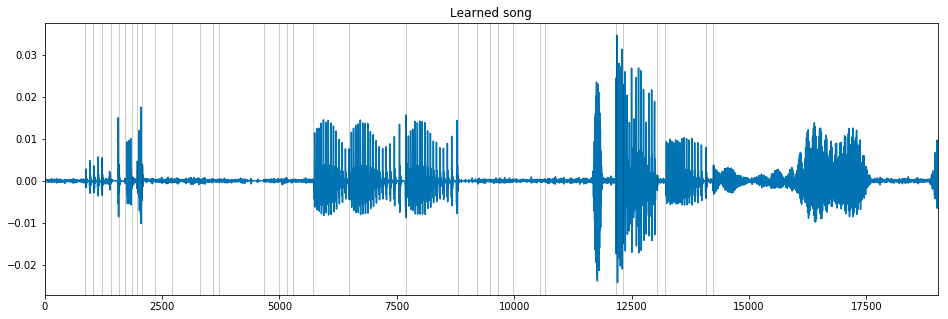

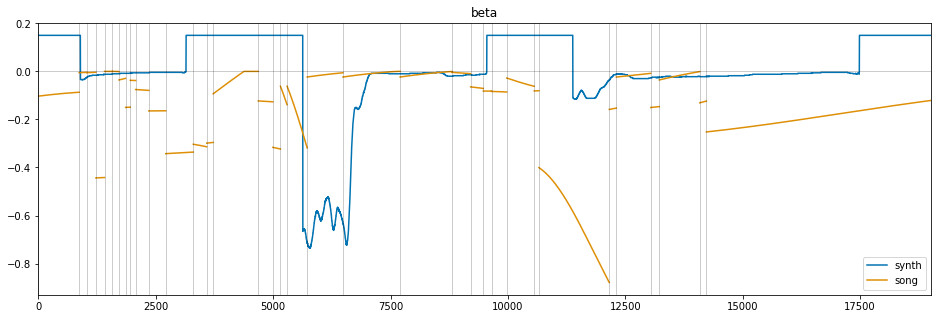

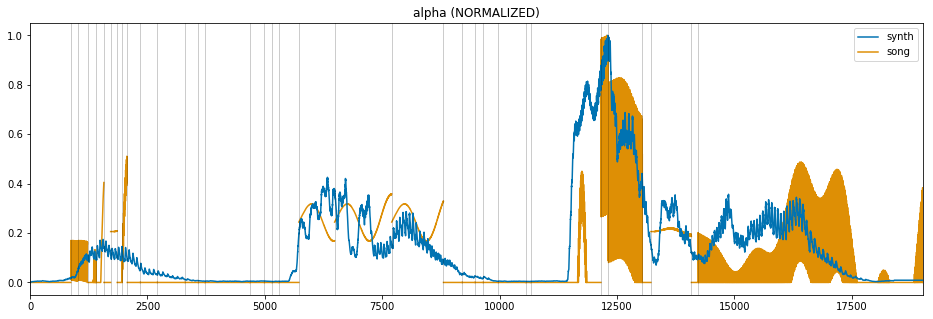

In [21]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(song)
plt.xlim(0, len(song))
plot_gesture_starts(g_starts)
plt.title("Learned song")
plt.show()

# Comparison between learnt beta and tutor's beta
plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_ab[:, 1], label="synth")
plt.plot(ab[:, 1], label="song")
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2)
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)
plt.legend()
plt.title("beta")

# Normalization for easier comparison between learnt alpha and tutor's alpha
a_t = (synth_ab[:, 0] - np.min(synth_ab[:, 0])) / (np.max(synth_ab[:, 0]) - np.min(synth_ab[:, 0]))
a_s = (ab[:,0] - np.nanmin(ab[:,0])) / (np.nanmax(ab[:,0]) - np.nanmin(ab[:,0]))

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
plt.title("alpha (NORMALIZED)")
# Inversion of the plotting order
line1, = plt.plot(a_s, label="song", color="C1")
line2, = plt.plot(a_t, label="synth", color="C0")
ax.legend((line2, line1), ("synth", "song"))
# -- not normalized --
# plt.plot(synth_ab[:, 0], alpha=0.3, label="synth")
# plt.plot(ab[:,0], alpha=0.7, label="song")
plt.xlim(0, ab.shape[0])
plot_gesture_starts(g_starts)

In [22]:
# number of gestures in a learnt song
print("index of the best song:", best)
print(len(smodels[best].gestures))

index of the best song: 0
35


In [23]:
mean_gesture_nb = 0
for s in smodels:
    print(len(s.gestures))
    mean_gesture_nb += len(s.gestures)
    
mean_gesture_nb /= len(smodels)

print("mean number of gesture: {}".format(mean_gesture_nb))

35
35
35
mean number of gesture: 35.0


In [24]:
# numbers of gtes in the tutor song
gtes = np.loadtxt('../data/{}_gte.dat'.format(song_name))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]
print(len(gtes))
print(len(true_gtes))

24
20


# Alpha - Beta of songs

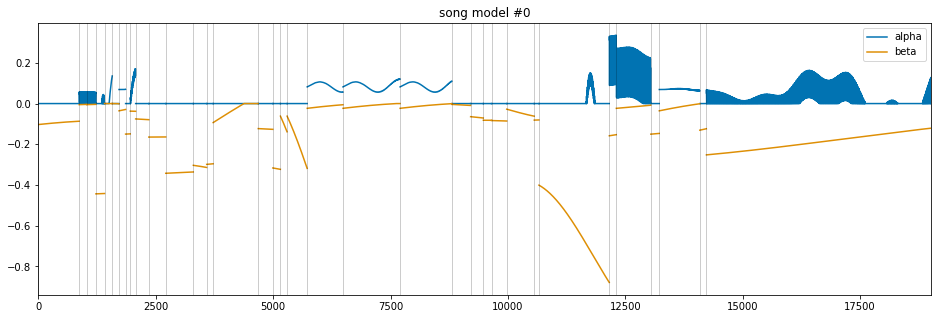

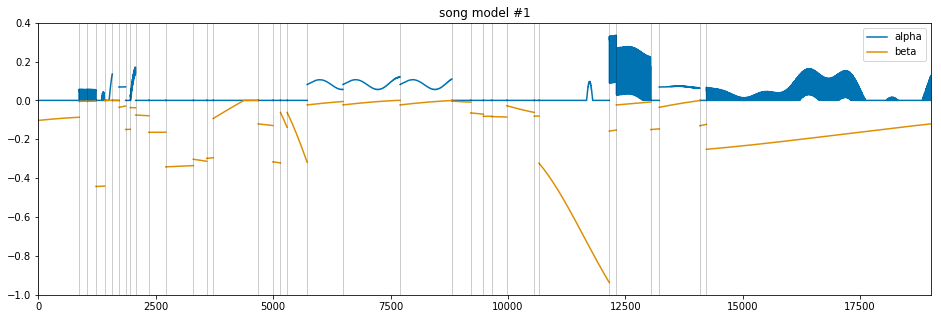

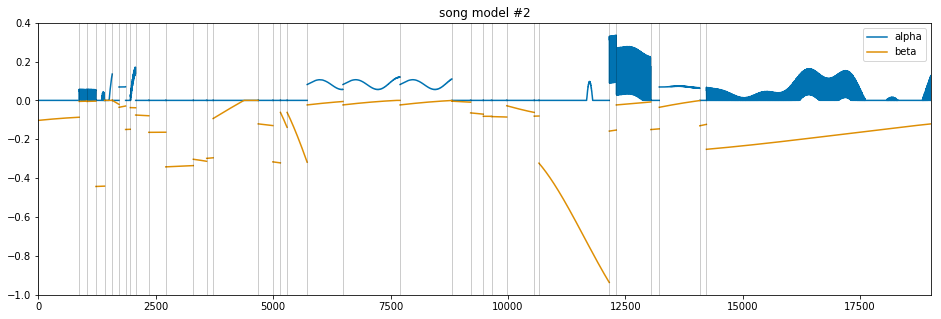

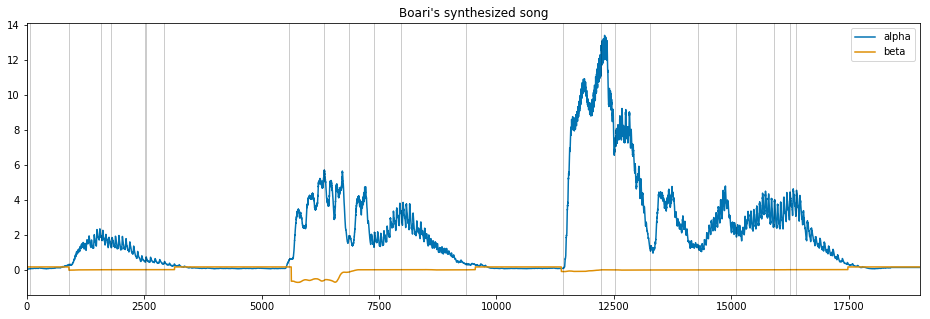

In [25]:
# plot the (alpha, beta) for the final songs and 
# the (alpha, beta) of the tutor's song with the GTEs
for i in range(len(rd['songs'].iloc[day_index])):
    plt.figure(figsize=(fig_width, fig_height))
    ab_tmp = rd['songs'].iloc[day_index][i].gen_alphabeta()
    # Allow to split the gesture on the alpha and beta plots
    for start, g in rd['songs'].iloc[day_index][i].gestures:
        ab_tmp[start] = np.nan
    plt.plot(ab_tmp[:, 0], label="alpha")
    plt.plot(ab_tmp[:, 1], label="beta")
    plt.xlim((0, ab_tmp.shape[0]))
    #plt.yticks([], [])
    for gesture in rd['songs'].iloc[day_index][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
    plt.title("song model #{}".format(i))
    plt.legend()

# Tutor song + gtes of the best optimised song
plt.figure(figsize=(fig_width,fig_height))
plt.plot(synth_ab[:,0], label="alpha")
plt.plot(synth_ab[:,1], label="beta")
plt.xlim((0, ab.shape[0]))
for gesture in gtes:
    start = gesture
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.title("Boari's synthesized song")
plt.legend()
plt.show()

# Calculation of each feature error

threshold: -1.0192144792730786
err_feat_vect:  [26.78346469  3.20867943 19.18938996 17.86080862 12.95628621  0.
  6.62458036]


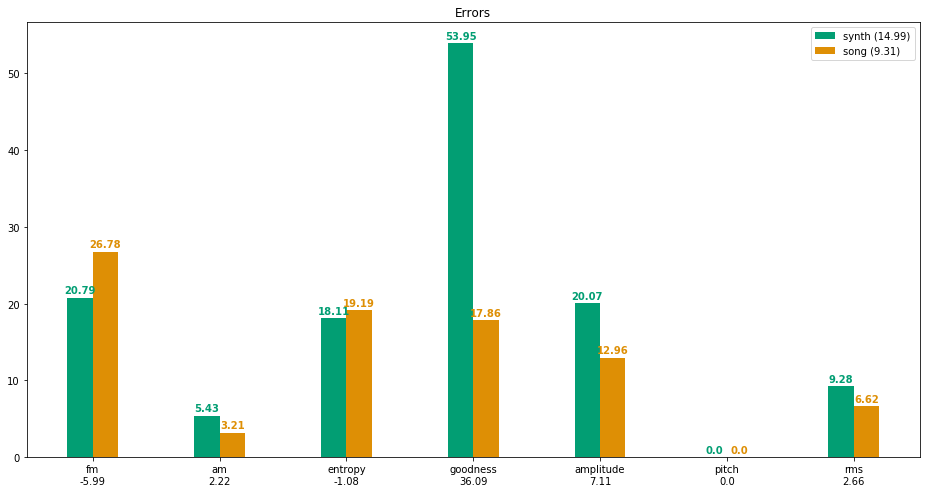

In [26]:
# Code inspired from cmp_2_sim.py, the end of plot_fig function
color_synth = "C2"
color_song = "C1"
    
amp, th = carac_to_calculate_err_of_synth(synth_song,
                                          tfeat["amplitude"])

print("threshold:", th)

mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

err_feat_vect = err_per_feat(mtutor, msong)
err_feat_vect_synth = err_per_feat(mtutor[amp > th],
                                   msynth[amp > th])

print("err_feat_vect: ", err_feat_vect)

x = np.arange(0,len(err_feat_vect))
fig = plt.figure(figsize=(fig_width,8))
ax = fig.gca()
synth_score = round(score, 2)
song_score = round(best_score, 2)
synth_label = "synth ({})".format(synth_score)
song_label = "song ({})".format(song_score)
plt.bar(x - 0.1, err_feat_vect_synth,
        width=0.2, align='center',
        label=synth_label, color=color_synth)
plt.bar(x + 0.1, err_feat_vect,
        width=0.2, align='center',
        label=song_label, color=color_song)
delta = err_feat_vect_synth - err_feat_vect
xlabels = [fnames[i] + '\n' + str(round(delta[i], 2)) for i in range(len(fnames))]
plt.xticks(x, xlabels)
# plt.xticks(x, fnames)
shift = np.max(np.concatenate((err_feat_vect_synth,
                               err_feat_vect))) / 100
for index in x:
    v_synth = err_feat_vect_synth[index]
    v_song = err_feat_vect[index]
    ax.text(index - 0.1, v_synth + shift,
            str(round(v_synth, 2)),
            color=color_synth, ha="center", fontweight='bold')
    ax.text(index + 0.1, v_song + shift,
            str(round(v_song, 2)),
            color=color_song, ha="center", fontweight='bold')
plt.legend()
plt.title("Errors")
plt.show()

In [27]:
import math
print(np.sum(amp > th))
print(len(amp))
print(math.sqrt(np.sum(err_feat_vect_synth)) / np.sum(amp > th) * len(amp))
print(math.sqrt(np.sum(err_feat_vect)))

358
475
14.989055730662681
9.307159033875688


# Night error

In [28]:
nights_errors = []

for i_after_night in range(2, len(rd) - 2, 2):
#     score_after_night = rd[i_after_night]['scores']
    nights_errors.append(rd['scores'].iloc[i_after_night] - rd['scores'].iloc[i_after_night - 1])

nights_errors = np.asarray(nights_errors)

mean_nights_errors = np.mean(nights_errors, axis=1)

total_mean_nights_errors = np.mean(mean_nights_errors)

print(total_mean_nights_errors)

0.3067353296382322


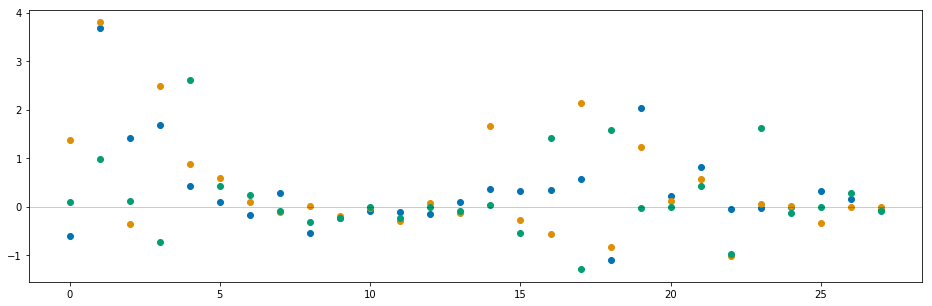

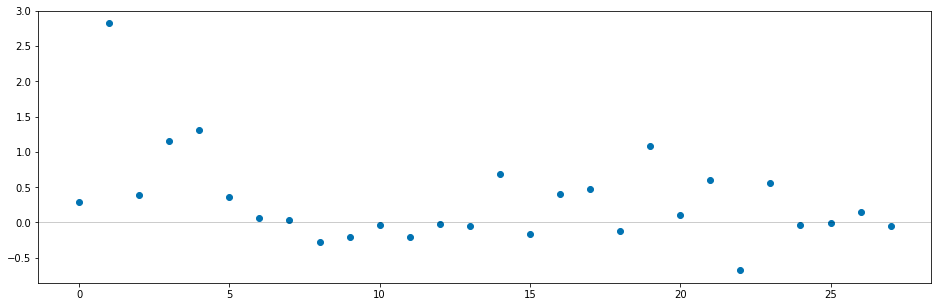

In [29]:
plt.figure(figsize=(fig_width,fig_height))
for i in range(len(nights_errors.T)):
    plt.plot(nights_errors.T[i], 'o')
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, label="zero")
plt.show()

plt.figure(figsize=(fig_width,fig_height))
plt.plot(mean_nights_errors, 'o')
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, label="zero")
plt.show()

In [30]:
for i in range(run_param['concurrent']):
    print("mean_error per night for 1 song:",
          np.mean(nights_errors.T[i]))
    print("final score:", rd['scores'].iloc[day_index][i])

mean_error per night for 1 song: 0.34638824004532304
final score: 9.307159033875688
mean_error per night for 1 song: 0.39247665870504533
final score: 9.33983500034281
mean_error per night for 1 song: 0.1813410901643284
final score: 9.338583374426007


# TEST

look specific moment (see day_index)

scores on day_index 6: [15.04194396 13.68931465 14.15921745]
scores on day_index 12: [14.05894295 14.0752468  14.36204668]


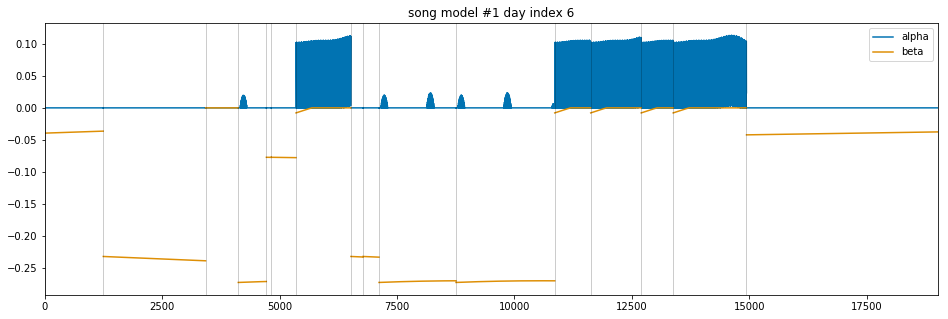

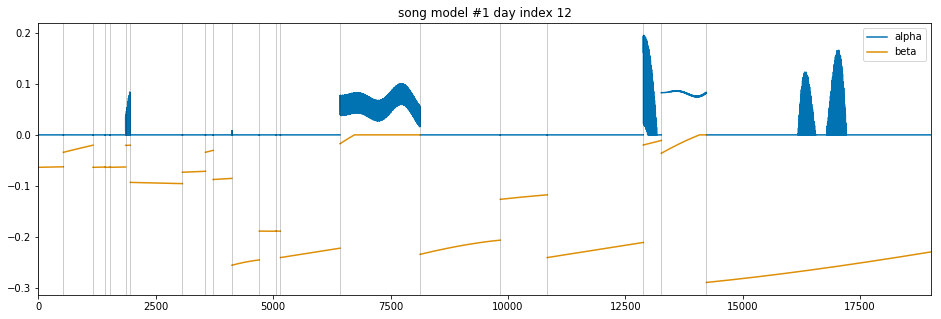

In [58]:
# plot the (alpha, beta) of songs at day_index + GTE
for day_index in [6, 12]:
    print("scores on day_index {}: {}".format(day_index, rd['scores'].iloc[day_index]))
    i = 1
#     for i in range(len(rd['songs'].iloc[day_index])):
    plt.figure(figsize=(fig_width, fig_height))
    ab_tmp = rd['songs'].iloc[day_index][i].gen_alphabeta()
    # Allow to split the gesture on the alpha and beta plots
    for start, g in rd['songs'].iloc[day_index][i].gestures:
        ab_tmp[start] = np.nan
    plt.plot(ab_tmp[:, 0], label="alpha")
    plt.plot(ab_tmp[:, 1], label="beta")
    plt.xlim((0, ab_tmp.shape[0]))
    for gesture in rd['songs'].iloc[day_index][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
    plt.title("song model #{} day index {}".format(i, day_index))
    plt.legend()
plt.show()

In [32]:
# # Code inspired from cmp_2_sim.py, the end of plot_fig function
# color_synth = "C2"
# color_song = "C1"
    
# amp, th = carac_to_calculate_err_of_synth(synth_song,
#                                           tfeat["amplitude"])

# print("threshold:", th)

# song = rd['songs'].iloc[6][1].gen_sound()
# best_score = rd['scores'].iloc[6][1]

# mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
# msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
# msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

# err_feat_vect = err_per_feat(mtutor, msong)
# err_feat_vect_synth = err_per_feat(mtutor[amp > th],
#                                    msynth[amp > th])

# x = np.arange(0,len(err_feat_vect))
# fig = plt.figure(figsize=(fig_width,8))
# ax = fig.gca()
# synth_score = round(score, 2)
# song_score = round(best_score, 2)
# synth_label = "synth ({})".format(synth_score)
# song_label = "song ({})".format(song_score)
# plt.bar(x - 0.1, err_feat_vect_synth,
#         width=0.2, align='center',
#         label=synth_label, color=color_synth)
# plt.bar(x + 0.1, err_feat_vect,
#         width=0.2, align='center',
#         label=song_label, color=color_song)
# plt.xticks(x, fnames)
# shift = np.max(np.concatenate((err_feat_vect_synth,
#                                err_feat_vect))) / 100
# for index in x:
#     v_synth = err_feat_vect_synth[index]
#     v_song = err_feat_vect[index]
#     ax.text(index - 0.1, v_synth + shift,
#             str(round(v_synth, 2)),
#             color=color_synth, ha="center", fontweight='bold')
#     ax.text(index + 0.1, v_song + shift,
#             str(round(v_song, 2)),
#             color=color_song, ha="center", fontweight='bold')
# plt.legend()
# plt.title("Errors")
# plt.show()

# #############################################################################################################

# sfeat = bsa.all_song_features(song, bsa.SR,
#                               freq_range=bsa.FREQ_RANGE,
#                               fft_step=bsa.FFT_STEP,
#                               fft_size=bsa.FFT_SIZE)
# song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(tutor_feat['amplitude'], label="tutor")
# plt.plot(song_feat['amplitude'], alpha=0.6, label="song")
# plot_gesture_starts(g_starts, scale=40)
# plt.xlim(0, len(tutor_feat['amplitude']))
# plt.legend()
# plt.title('amplitude')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.show()

# #############################################################################################################

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(song)
# plt.xlim(0, len(song))
# plt.show()

In [33]:
# # Code inspired from cmp_2_sim.py, the end of plot_fig function
# color_synth = "C2"
# color_song = "C1"
    
# amp, th = carac_to_calculate_err_of_synth(synth_song,
#                                           tfeat["amplitude"])

# print("threshold:", th)

# song = rd['songs'].iloc[12][1].gen_sound()
# best_score = rd['scores'].iloc[12][1]

# mtutor = bsa_measure(tutor, bsa.SR, run_param['coefs'], tfeat)
# msynth = bsa_measure(synth_song, bsa.SR, run_param['coefs'], tfeat)
# msong = bsa_measure(song, bsa.SR, run_param['coefs'], tfeat)

# err_feat_vect = err_per_feat(mtutor, msong)
# err_feat_vect_synth = err_per_feat(mtutor[amp > th],
#                                    msynth[amp > th])

# x = np.arange(0,len(err_feat_vect))
# fig = plt.figure(figsize=(fig_width,8))
# ax = fig.gca()
# synth_score = round(score, 2)
# song_score = round(best_score, 2)
# synth_label = "synth ({})".format(synth_score)
# song_label = "song ({})".format(song_score)
# plt.bar(x - 0.1, err_feat_vect_synth,
#         width=0.2, align='center',
#         label=synth_label, color=color_synth)
# plt.bar(x + 0.1, err_feat_vect,
#         width=0.2, align='center',
#         label=song_label, color=color_song)
# plt.xticks(x, fnames)
# shift = np.max(np.concatenate((err_feat_vect_synth,
#                                err_feat_vect))) / 100
# for index in x:
#     v_synth = err_feat_vect_synth[index]
#     v_song = err_feat_vect[index]
#     ax.text(index - 0.1, v_synth + shift,
#             str(round(v_synth, 2)),
#             color=color_synth, ha="center", fontweight='bold')
#     ax.text(index + 0.1, v_song + shift,
#             str(round(v_song, 2)),
#             color=color_song, ha="center", fontweight='bold')
# plt.legend()
# plt.title("Errors")
# plt.show()
# #############################################################################################################
# sfeat = bsa.all_song_features(song, bsa.SR,
#                               freq_range=bsa.FREQ_RANGE,
#                               fft_step=bsa.FFT_STEP,
#                               fft_size=bsa.FFT_SIZE)
# song_feat = bsa.rescaling_with_tutor_values(tfeat, sfeat)

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(tutor_feat['amplitude'], label="tutor")
# plt.plot(song_feat['amplitude'], alpha=0.6, label="song")
# plot_gesture_starts(g_starts, scale=40)
# plt.xlim(0, len(tutor_feat['amplitude']))
# plt.legend()
# plt.title('amplitude')
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.show()

# #############################################################################################################

# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(song)
# plt.xlim(0, len(song))
# plt.show()